# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                        
Sample_038  A0A087X0M8                               15.391
Sample_045  P0C0L4                                   21.099
Sample_020  P61278                                   18.609
Sample_117  E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3   13.909
Sample_081  F5H3H7;Q9Y644                            13.883
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                      
Sample_073  H0Y7T8;P49418;P49418-2                 12.936
Sample_012  P78539;P78539-2;P78539-3;P78539-5      10.865
Sample_059  E9PHN6;E9PHN7;F6XZQ7;P28161;P28161-2   11.605
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.029
            A0A075B6Q5                 12.729
            A0A075B6R2                 13.240
            A0A075B6S5                 13.089
            A0A087WSY4                 12.549
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.303
            Q9UI40;Q9UI40-2            12.370
            Q9UIW2                     12.320
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.279
            Q9UP79                     12.332
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.381,15.050,16.842,19.863,13.858,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,13.472,19.067,...,15.528,15.576,11.536,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,14.113,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,7.652,17.705,17.039,14.740,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.359,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.740,15.345,17.084,18.708,14.249,19.433,8.239,9.509
Sample_207,15.739,16.877,15.469,16.898,14.370,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.054,12.255,11.975,13.242,11.883,13.109,11.153,13.294,12.777,13.124
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.754,19.067,16.127,...,12.993,12.217,12.190,11.369,13.545,13.614,12.049,11.676,11.374,13.771
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.242,13.906,11.957,12.867,13.374,12.227,12.045,13.249,13.792,14.399
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.725,12.958,13.615,13.356,13.480,11.386,11.900,13.273,13.367,12.579
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.175,12.398,13.391,12.014,14.957,13.042,12.038,13.502,13.676,12.916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.365,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 361.11it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.91it/s]

100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.37it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.73it/s]

100%|██████████| 4/4 [00:00<00:00,  4.32it/s]

100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.70it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.12it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.97it/s]

100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.30it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.70it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.47it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.59it/s]

100%|██████████| 6/6 [00:01<00:00,  4.48it/s]

100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.15it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.12it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.00it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.60it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.44it/s]

100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

100%|██████████| 7/7 [00:01<00:00,  4.89it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.89it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.94it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.00it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.48it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.57it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.55it/s]

100%|██████████| 8/8 [00:01<00:00,  3.87it/s]

100%|██████████| 8/8 [00:01<00:00,  4.53it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.68it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.44it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.41it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.03it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.25it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.73it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.46it/s]

100%|██████████| 9/9 [00:02<00:00,  2.88it/s]

100%|██████████| 9/9 [00:02<00:00,  3.80it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.78it/s]

 30%|███       | 3/10 [00:00<00:01,  6.02it/s]

 40%|████      | 4/10 [00:00<00:01,  5.36it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.34it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.73it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.38it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.11it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.90it/s]

100%|██████████| 10/10 [00:02<00:00,  2.84it/s]

100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.11it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.97it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.91it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.44it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.22it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.93it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.77it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.72it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.68it/s]

100%|██████████| 11/11 [00:03<00:00,  2.65it/s]

100%|██████████| 11/11 [00:03<00:00,  3.08it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.37it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.40it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.74it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.24it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.98it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.92it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.91it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.85it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.93it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.02it/s]

100%|██████████| 12/12 [00:03<00:00,  3.15it/s]

100%|██████████| 12/12 [00:03<00:00,  3.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.44it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.21it/s]

 31%|███       | 4/13 [00:01<00:02,  3.63it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.55it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.35it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.06it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.88it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.71it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.57it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.65it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.73it/s]

100%|██████████| 13/13 [00:04<00:00,  2.86it/s]

100%|██████████| 13/13 [00:04<00:00,  3.05it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.78it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.89it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.51it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.28it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.92it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.82it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.76it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.71it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.72it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.54it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.64it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.91it/s]

100%|██████████| 14/14 [00:04<00:00,  3.10it/s]

100%|██████████| 14/14 [00:04<00:00,  3.01it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.47it/s]

 20%|██        | 3/15 [00:00<00:02,  4.33it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.85it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.51it/s]

 40%|████      | 6/15 [00:01<00:02,  3.14it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.97it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.72it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.72it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.77it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.98it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.16it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.19it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.01it/s]

100%|██████████| 15/15 [00:04<00:00,  3.19it/s]

100%|██████████| 15/15 [00:04<00:00,  3.17it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.044 0.015          0.788 0.316       0.134   
2             0.004 0.002      0.048 0.022          0.648 0.137       0.534   
3             0.005 0.005      0.063 0.021          0.730 0.105       0.640   
4             0.004 0.003      0.037 0.009          0.771 0.091       0.680   
5             0.004 0.002      0.039 0.011          0.719 0.082       0.682   
6             0.005 0.004      0.051 0.024          0.741 0.088       0.740   
7             0.006 0.005      0.066 0.026          0.735 0.088       0.735   
8             0.006 0.006      0.063 0.027          0.818 0.078       0.824   
9             0.006 0.005      0.059 0.026          0.822 0.073       0.810   
10            0.006 0.004      0.053 0.026          0.805 0.086       0.820   
11            0.005 0.004      0.046 0.017          0.820 0.084       0.828   
12            0.005 0.005      0.045 0.022          0.823 0.081       0.823   
13            0.005 0.003      0.043 0.016          0.821 0.083       0.824   
14            0.004 0.002      0.044 0.016          0.824 0.077       0.828   
15            0.004 0.002      0.040 0.012          0.823 0.077       0.829   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.091   0.220 0.134                  0.559 0.044        0.857   
2          0.142   0.574 0.117                  0.656 0.080        0.731   
3          0.118   0.675 0.093                  0.731 0.068        0.786   
4          0.114   0.716 0.084                  0.765 0.063        0.818   
5          0.095   0.696 0.072                  0.743 0.058        0.865   
6          0.113   0.735 0.079                  0.773 0.065        0.876   
7          0.111   0.730 0.079                  0.769 0.066        0.874   
8          0.099   0.817 0.068                  0.843 0.056        0.917   
9          0.101   0.811 0.065                  0.839 0.053        0.916   
10         0.106   0.808 0.078                  0.835 0.067        0.916   
11         0.101   0.821 0.078                  0.847 0.067        0.920   
12         0.102   0.820 0.076                  0.846 0.064        0.920   
13         0.100   0.819 0.074                  0.845 0.063        0.919   
14         0.104   0.822 0.073                  0.848 0.062        0.918   
15         0.105   0.822 0.072                  0.848 0.062        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.830 0.092        210.000 0.000  
2          0.087                  0.679 0.098        210.000 0.000  
3          0.065                  0.737 0.086        210.000 0.000  
4          0.065                  0.787 0.092        210.000 0.000  
5          0.053                  0.844 0.060        210.000 0.000  
6          0.052                  0.842 0.065        210.000 0.000  
7          0.052                  0.840 0.065        210.000 0.000  
8          0.044                  0.907 0.045        210.000 0.000  
9          0.044                  0.906 0.046        210.000 0.000  
10         0.046                  0.905 0.048        210.000 0.000  
11         0.046                  0.907 0.048        210.000 0.000  
12         0.046                  0.903 0.051        210.000 0.000  
13         0.046                  0.903 0.051        210.000 0.000  
14         0.046                  0.901 0.052        210.000 0.000  
15         0.046                  0.900 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 314.32it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.20it/s]

100%|██████████| 3/3 [00:00<00:00,  2.97it/s]

100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.46it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.27it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.27it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.96it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.56it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.89it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.51it/s]

100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.78it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.36it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.00it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.78it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.66it/s]

100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.75it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.30it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.15it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.02it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.96it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.76it/s]

100%|██████████| 8/8 [00:01<00:00,  3.73it/s]

100%|██████████| 8/8 [00:01<00:00,  4.01it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.30it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.94it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.32it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.63it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.54it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.50it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.41it/s]

100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.58it/s]

 30%|███       | 3/10 [00:00<00:01,  4.50it/s]

 40%|████      | 4/10 [00:00<00:01,  4.22it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.04it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.97it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.24it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.75it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.52it/s]

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

100%|██████████| 10/10 [00:03<00:00,  3.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.79it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.68it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.97it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.58it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.46it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.43it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.46it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.13it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.35it/s]

100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

100%|██████████| 11/11 [00:03<00:00,  3.57it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.09it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.90it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.52it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.39it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.40it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.14it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.70it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.48it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.31it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.31it/s]

100%|██████████| 12/12 [00:04<00:00,  2.48it/s]

100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.94it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.09it/s]

 31%|███       | 4/13 [00:01<00:02,  3.78it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.38it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.15it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.13it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.34it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.39it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.19it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.27it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.41it/s]

100%|██████████| 13/13 [00:03<00:00,  3.36it/s]

100%|██████████| 13/13 [00:03<00:00,  3.42it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.57it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.72it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.07it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.08it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.09it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.13it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.96it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.49it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.34it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.14it/s]

 86%|████████▌ | 12/14 [00:04<00:01,  1.99it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.91it/s]

100%|██████████| 14/14 [00:05<00:00,  1.90it/s]

100%|██████████| 14/14 [00:05<00:00,  2.42it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.94it/s]

 20%|██        | 3/15 [00:00<00:03,  3.39it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.04it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.45it/s]

 40%|████      | 6/15 [00:02<00:04,  2.20it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.14it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.14it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.38it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.47it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.69it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.80it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.74it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.69it/s]

100%|██████████| 15/15 [00:05<00:00,  2.74it/s]

100%|██████████| 15/15 [00:05<00:00,  2.63it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.060 0.024          0.879 0.203       0.163   
2             0.005 0.005      0.050 0.018          0.782 0.089       0.715   
3             0.004 0.003      0.045 0.015          0.794 0.099       0.745   
4             0.005 0.004      0.041 0.012          0.806 0.092       0.774   
5             0.004 0.004      0.047 0.018          0.803 0.088       0.787   
6             0.004 0.002      0.039 0.012          0.800 0.087       0.763   
7             0.004 0.005      0.038 0.013          0.793 0.085       0.777   
8             0.004 0.003      0.037 0.008          0.816 0.091       0.785   
9             0.005 0.004      0.062 0.021          0.801 0.093       0.780   
10            0.004 0.002      0.037 0.010          0.801 0.096       0.798   
11            0.005 0.007      0.050 0.022          0.838 0.086       0.820   
12            0.004 0.003      0.039 0.009          0.828 0.085       0.816   
13            0.004 0.003      0.049 0.020          0.835 0.085       0.820   
14            0.006 0.006      0.053 0.024          0.849 0.082       0.825   
15            0.003 0.000      0.033 0.004          0.841 0.086       0.824   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.089   0.265 0.126                  0.573 0.043        0.849   
2          0.109   0.741 0.077                  0.783 0.060        0.860   
3          0.104   0.763 0.077                  0.799 0.063        0.865   
4          0.104   0.784 0.069                  0.816 0.056        0.877   
5          0.101   0.790 0.071                  0.821 0.060        0.889   
6          0.107   0.776 0.078                  0.810 0.064        0.886   
7          0.093   0.781 0.066                  0.812 0.055        0.887   
8          0.094   0.795 0.065                  0.825 0.054        0.891   
9          0.105   0.785 0.073                  0.817 0.061        0.892   
10         0.099   0.794 0.067                  0.823 0.057        0.898   
11         0.093   0.825 0.067                  0.850 0.056        0.914   
12         0.097   0.818 0.069                  0.844 0.059        0.913   
13         0.089   0.824 0.067                  0.849 0.057        0.915   
14         0.076   0.833 0.055                  0.857 0.047        0.916   
15         0.078   0.828 0.056                  0.852 0.048        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.059                  0.823 0.081        210.000 0.000  
3          0.057                  0.847 0.069        210.000 0.000  
4          0.052                  0.854 0.067        210.000 0.000  
5          0.052                  0.869 0.064        210.000 0.000  
6          0.051                  0.858 0.066        210.000 0.000  
7          0.050                  0.859 0.065        210.000 0.000  
8          0.050                  0.862 0.065        210.000 0.000  
9          0.052                  0.866 0.064        210.000 0.000  
10         0.051                  0.875 0.059        210.000 0.000  
11         0.048                  0.904 0.048        210.000 0.000  
12         0.049                  0.905 0.047        210.000 0.000  
13         0.048                  0.907 0.047        210.000 0.000  
14         0.044                  0.911 0.043        210.000 0.000  
15         0.043                  0.911 0.044 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1169.31it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 21.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 38.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 27.37it/s]

100%|██████████| 4/4 [00:00<00:00, 23.05it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 29.71it/s]

100%|██████████| 5/5 [00:00<00:00, 22.68it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.42it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 16.21it/s]

100%|██████████| 6/6 [00:00<00:00, 15.82it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 24.65it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 18.38it/s]

100%|██████████| 7/7 [00:00<00:00, 18.24it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.63it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.62it/s]

100%|██████████| 8/8 [00:00<00:00, 14.90it/s]

100%|██████████| 8/8 [00:00<00:00, 15.46it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.98it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 18.86it/s]

100%|██████████| 9/9 [00:00<00:00, 18.94it/s]

100%|██████████| 9/9 [00:00<00:00, 19.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.27it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.66it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.05it/s]

100%|██████████| 10/10 [00:00<00:00, 14.78it/s]

100%|██████████| 10/10 [00:00<00:00, 15.29it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 23.06it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.40it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 15.26it/s]

 91%|█████████ | 10/11 [00:00<00:00, 14.37it/s]

100%|██████████| 11/11 [00:00<00:00, 15.26it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.63it/s]

 50%|█████     | 6/12 [00:00<00:00, 14.34it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.36it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.10it/s]

100%|██████████| 12/12 [00:00<00:00, 14.10it/s]

100%|██████████| 12/12 [00:00<00:00, 14.53it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.20it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.79it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.13it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.24it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.50it/s]

100%|██████████| 13/13 [00:00<00:00, 15.71it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 24.74it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.96it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.34it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 15.45it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.27it/s]

100%|██████████| 14/14 [00:00<00:00, 15.62it/s]

100%|██████████| 14/14 [00:00<00:00, 16.21it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 25.52it/s]

 40%|████      | 6/15 [00:00<00:00, 17.54it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.51it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.51it/s]

 80%|████████  | 12/15 [00:00<00:00, 16.16it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.33it/s]

100%|██████████| 15/15 [00:00<00:00, 16.12it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.045 0.020          0.277 0.441       0.018   
2             0.002 0.001      0.025 0.008          0.690 0.218       0.182   
3             0.003 0.003      0.039 0.016          0.570 0.115       0.388   
4             0.003 0.002      0.038 0.012          0.568 0.112       0.390   
5             0.006 0.005      0.046 0.016          0.565 0.108       0.414   
6             0.004 0.003      0.036 0.011          0.534 0.081       0.408   
7             0.004 0.003      0.043 0.015          0.557 0.113       0.431   
8             0.003 0.001      0.036 0.010          0.572 0.100       0.462   
9             0.005 0.004      0.041 0.013          0.569 0.094       0.465   
10            0.004 0.003      0.039 0.011          0.560 0.091       0.471   
11            0.005 0.004      0.044 0.013          0.559 0.094       0.468   
12            0.004 0.003      0.042 0.013          0.566 0.092       0.481   
13            0.005 0.004      0.046 0.017          0.562 0.088       0.478   
14            0.005 0.004      0.047 0.017          0.561 0.097       0.515   
15            0.005 0.004      0.051 0.018          0.575 0.093       0.519   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.029   0.034 0.054                  0.507 0.016        0.702   
2          0.090   0.272 0.105                  0.554 0.032        0.664   
3          0.106   0.454 0.092                  0.584 0.058        0.641   
4          0.110   0.453 0.094                  0.583 0.058        0.636   
5          0.104   0.471 0.089                  0.588 0.060        0.649   
6          0.108   0.457 0.084                  0.575 0.055        0.639   
7          0.100   0.478 0.086                  0.585 0.064        0.640   
8          0.109   0.505 0.090                  0.603 0.067        0.646   
9          0.112   0.504 0.084                  0.600 0.062        0.645   
10         0.107   0.504 0.079                  0.597 0.058        0.639   
11         0.111   0.502 0.084                  0.596 0.061        0.629   
12         0.106   0.513 0.078                  0.603 0.058        0.631   
13         0.107   0.509 0.078                  0.600 0.055        0.630   
14         0.108   0.530 0.080                  0.606 0.065        0.671   
15         0.117   0.538 0.081                  0.616 0.060        0.676   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.664 0.075        210.000 0.000  
2          0.075                  0.626 0.086        210.000 0.000  
3          0.071                  0.593 0.069        210.000 0.000  
4          0.067                  0.588 0.068        210.000 0.000  
5          0.073                  0.593 0.079        210.000 0.000  
6          0.070                  0.586 0.075        210.000 0.000  
7          0.075                  0.576 0.081        210.000 0.000  
8          0.075                  0.593 0.082        210.000 0.000  
9          0.078                  0.589 0.079        210.000 0.000  
10         0.076                  0.604 0.082        210.000 0.000  
11         0.077                  0.595 0.081        210.000 0.000  
12         0.077                  0.597 0.081        210.000 0.000  
13         0.080                  0.596 0.080        210.000 0.000  
14         0.072                  0.608 0.075        210.000 0.000  
15         0.076                  0.614 0.075 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,14,5
score_time,7,9,15
test_precision,14,1,2
test_recall,15,14,15
test_f1,14,14,15
test_balanced_accuracy,14,14,15
test_roc_auc,11,15,1
test_average_precision,8,15,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.41it/s]

 20%|██        | 3/15 [00:00<00:02,  5.14it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.77it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.20it/s]

 40%|████      | 6/15 [00:01<00:03,  2.93it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.76it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.85it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.90it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.03it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.01it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.26it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.45it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.54it/s]

100%|██████████| 15/15 [00:04<00:00,  3.61it/s]

100%|██████████| 15/15 [00:04<00:00,  3.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1195.64it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.97it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.84it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.43it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.08it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.98it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.24it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.43it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.35it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.55it/s]

100%|██████████| 11/11 [00:03<00:00,  3.56it/s]

100%|██████████| 11/11 [00:03<00:00,  3.46it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


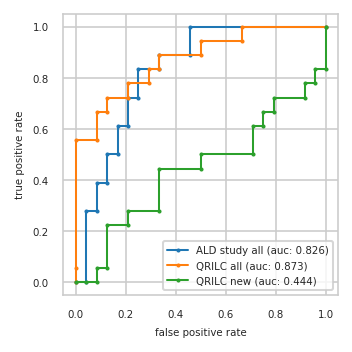

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.042 0.000     0.000 0.056     0.042 0.000
2          0.042 0.278     0.000 0.556     0.083 0.000
3          0.083 0.278     0.083 0.556     0.083 0.056
4          0.083 0.389     0.083 0.667     0.125 0.056
5          0.125 0.389     0.125 0.667     0.125 0.222
6          0.125 0.500     0.125 0.722     0.208 0.222
7          0.167 0.500     0.208 0.722     0.208 0.278
8          0.167 0.611     0.208 0.778     0.333 0.278
9          0.208 0.611     0.292 0.778     0.333 0.444
10         0.208 0.722     0.292 0.833     0.500 0.444
11         0.250 0.722     0.333 0.833     0.500 0.500
12         0.250 0.833     0.333 0.889     0.708 0.500
13         0.333 0.833     0.500 0.889     0.708 0.611
14         0.333 0.889     0.500 0.944     0.750 0.611
15         0.458 0.889     0.667 0.944     0.750 0.667
16         0.458 1.000     0.667 1.000     0.792 0.667
17         1.000 1.000     1.000 1.000     0.792 0.722
18           NaN   NaN       NaN   NaN     0.917 0.722
19           NaN   NaN       NaN   NaN     0.917 0.778
20           NaN   NaN       NaN   NaN     0.958 0.778
21           NaN   NaN       NaN   NaN     0.958 0.833
22           NaN   NaN       NaN   NaN     1.000 0.833
23           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
1,Q8NCL4,A0A0A0MRJ7;P12259,None
2,P01701,P08670,None
3,Q02818,P10636-2;P10636-6,None
4,P61981,P14174,None
5,P04075,P61981,None
6,P14174,P04075,None
7,P00338;P00338-3,P63104,None
8,Q9Y2T3;Q9Y2T3-3,C9JF17;P05090,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


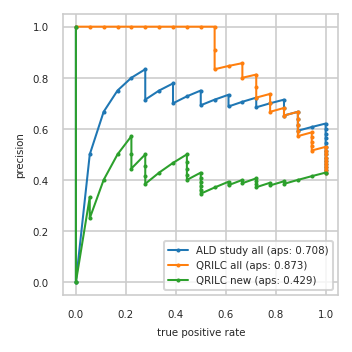

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.415 0.944
2          0.450 1.000     0.450 1.000     0.400 0.889
3          0.462 1.000     0.462 1.000     0.385 0.833
4          0.474 1.000     0.474 1.000     0.395 0.833
5          0.486 1.000     0.486 1.000     0.378 0.778
6          0.500 1.000     0.500 1.000     0.389 0.778
7          0.514 1.000     0.514 1.000     0.371 0.722
8          0.529 1.000     0.529 1.000     0.382 0.722
9          0.545 1.000     0.515 0.944     0.394 0.722
10         0.562 1.000     0.531 0.944     0.406 0.722
11         0.581 1.000     0.548 0.944     0.387 0.667
12         0.600 1.000     0.567 0.944     0.400 0.667
13         0.621 1.000     0.586 0.944     0.379 0.611
14         0.607 0.944     0.571 0.889     0.393 0.611
15         0.593 0.889     0.593 0.889     0.370 0.556
16         0.615 0.889     0.615 0.889     0.346 0.500
17         0.640 0.889     0.640 0.889     0.360 0.500
18         0.667 0.889     0.667 0.889     0.375 0.500
19         0.652 0.833     0.652 0.833     0.391 0.500
20         0.682 0.833     0.682 0.833     0.409 0.500
21         0.714 0.833     0.667 0.778     0.429 0.500
22         0.700 0.778     0.700 0.778     0.400 0.444
23         0.684 0.722     0.737 0.778     0.421 0.444
24         0.722 0.722     0.722 0.722     0.444 0.444
25         0.706 0.667     0.765 0.722     0.471 0.444
26         0.688 0.611     0.812 0.722     0.500 0.444
27         0.733 0.611     0.800 0.667     0.467 0.389
28         0.714 0.556     0.857 0.667     0.429 0.333
29         0.692 0.500     0.846 0.611     0.385 0.278
30         0.750 0.500     0.833 0.556     0.417 0.278
31         0.727 0.444     0.909 0.556     0.455 0.278
32         0.700 0.389     1.000 0.556     0.500 0.278
33         0.778 0.389     1.000 0.500     0.444 0.222
34         0.750 0.333     1.000 0.444     0.500 0.222
35         0.714 0.278     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.250 0.056
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


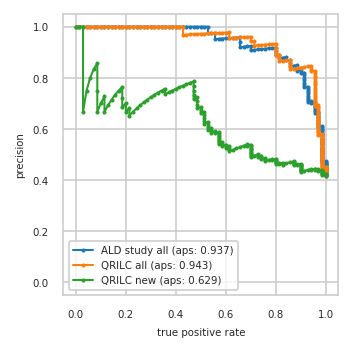

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


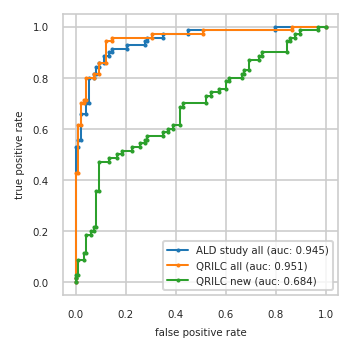

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}